In [2]:
using Flux, CSV, DataFrames, Statistics, Plots
include("Utils-quantile-cryptoretrain.jl")
# include("Utils-quantile-scrape-and-process-data.jl")

[ Info: Precompiling MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]


Main.utils

In [3]:
pwd()

"/Users/balaji/projects/deep-quantile/code/qreg_btceth/retrain/code"

# Quantile regression

We aim to predict the percentile for a particular variable $y$. The predicted value is $\hat{y}(\tau)$.

For predicting the mean $\hat{y}$, one typically uses the loss function known as the mean squared error, $MSE$:

\begin{equation}
MSE = \frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2
\end{equation}

where $\hat{y} = \beta X$.

Now for estimating $\hat{y}(\tau) = \beta(\tau)X$, one can use the mean absolute deviation $MAD$:

\begin{equation}
MAD = \frac{1}{N} \sum_{i=1}^{N} \rho_{\tau} (y_i - \hat{y}_i)
\end{equation}

where $\rho_{\tau} (\xi) = \tau \ max(\xi, 0) + (1 - \tau) \ max(-\xi, 0)$.

We find that the squared MAD (SMAD) produces less noisy results as an objective function so we use the SMAD.

## Define hyperparameters

Specify data file and hyperparameters.

"$\tau$" defines the percentile. For example, $\tau = 0.4$ aims to predict the value $\hat{y}$ where 60% of the data points should lie above the value $\hat{y}$.

"denselayers" defines the number of hidden layers in the neural network model.

"split" defines the proportion of samples to be allocated to training set.

"obs" is the observation period which contributes to our features for each sample point.

"hold" is the holding period over which we aim to estimate the returns of the stock.

"epochs" the number of training epochs.

"$\eta$" is the learning rate.

"dir" is the file directory.

"file" is the filename of the stock data. File format is assumed to be csv.

#### Get latest data to retrain

### Training 

In [4]:
dir = "../data/";

file = "crypto_df"
hp = Dict(
    "dir" => dir,
    "file" => file,
    "obs" => 12,
    "hold" => 2,
    "τ" => 0.4,
    "split" => 0.8,
    "epochs" => 45,
    "η" => 0.007,
    "denselayers" => [20],
    "optimiser" => AdaGrad,
#     "optimiser" => AdaDelta,
    "saveroot" => nothing,
    "seed" => 12
    )


Dict{String, Any} with 12 entries:
  "optimiser"   => AdaGrad
  "obs"         => 12
  "saveroot"    => nothing
  "hold"        => 2
  "split"       => 0.8
  "denselayers" => [20]
  "η"           => 0.007
  "epochs"      => 45
  "τ"           => 0.4
  "file"        => "crypto_df"
  "seed"        => 12
  "dir"         => "../data/"

In [5]:
res= utils.train(hp);

res.train_hist[end], res.test_hist[end]

([0.39086294416243655; 0.3934010152284264;;], [0.3939393939393939; 0.40404040404040403;;])

### Results from the trained model

In [6]:
quantile_train = res.train_hist[end]
c_train = findall(x->abs(x-hp["τ"])<0.03, quantile_train);
index_train = [k[1] for k in c_train] # index for those that passed the threshold

quantiles = res.test_hist[end]  # returns the quantile at the end of all training epochs
c = findall(x->abs(x-hp["τ"])<0.03, quantiles);
index = [k[1] for k in c] # index for those that passed the threshold i.e. quantile falles within +-0.03 of τ

ys_test = res.ys_test #true values of test set
filtered_ystest = [ys_test[:,i][index] for i in 1:size(ys_test)[2]];

select_top = length(index)

idx = [sortperm(i, rev=true) for i in filtered_ystest]
idx_select = [i[1:select_top] for i in idx]
filtered_returns  = [filtered_ystest[i][idx_select[i]] for i in 1:size(ys_test)[2]]
p = [sum(min.(filtered_returns[i],0))/select_top for i in 1:size(filtered_ystest)[1]];



0.7272727272727273


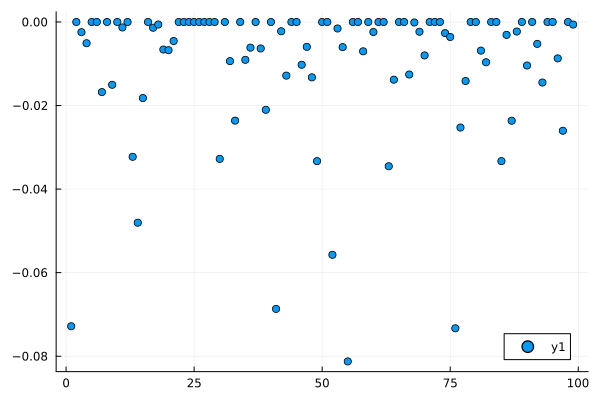

In [7]:
println(count(x->x>-0.01, p)/length(p))
scatter(p)

In [8]:
println("average profit: ", mean(p))

average profit: -0.009850244


#### A look at the losses across epochs

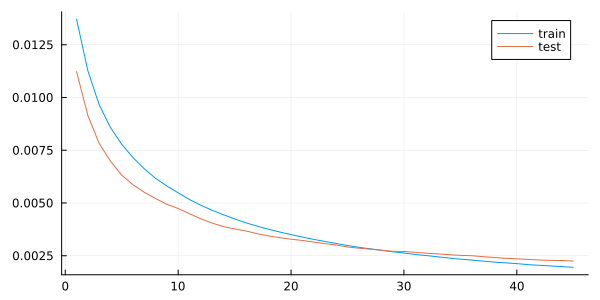

In [9]:
plot(res.smad_tr_hist, label = "train", size=(600,300))
plot!(res.smad_te_hist, label = "test", size=(600,300))

### Calculating pnl

In [12]:
using Distributions, Statistics

# Black-Scholes Put Option Formula

function put(s,k,r,σ,t)
    f = s*exp(r*t)
    m = log(f/k)
    df = exp(-r*t)
    d1 = (m + 0.5*σ*σ*t)/σ/sqrt(t)
    d2 = d1 - σ*sqrt(t)
    nd1 = cdf(Normal(0,1), d1)
    nd2 = cdf(Normal(0,1), d2)
    p = df*(nd1*f-nd2*k) - s + df*k
    return p
end

vol_window = hp["obs"] 
hold = hp["hold"]
filtered_returns1 = mapreduce(permutedims, vcat, filtered_returns)

pv = []
s = []
avg_p = []

for i in 1:select_top
    realised_vol = [sqrt(252/hold)*std(filtered_returns1[t-vol_window+1:t,i]) for t in vol_window:size(ys_test)[2]]
    put_prices = first.([put(1 .+filtered_returns1[t,i],1,0.03,realised_vol[t-vol_window+1], hold/252) for t in vol_window:size(ys_test)[2]])
    put_payout = [min(filtered_returns1[t,i], 0.0) for t in vol_window:size(ys_test)[2]]

    pnl = put_prices[1:end-1] .+ put_payout[2:end]
    avg_pnl = mean(pnl)*(252/hold)
    vol_pnl = std(pnl)*sqrt(252/hold)
    sharpe = avg_pnl/vol_pnl
    push!(pv, cumsum(pnl))
    push!(s, round(sharpe, digits=2))
    push!(avg_p, round(avg_pnl*100, digits=2))


    println("average annualised pnl: ", round(avg_pnl*100, digits=2),"%")
    println("sharpe ratio annualised: ", round(sharpe, digits=2))
end




average annualised pnl: 98.47%
sharpe ratio annualised: 4.03
average annualised pnl: 86.03%
sharpe ratio annualised: 3.02


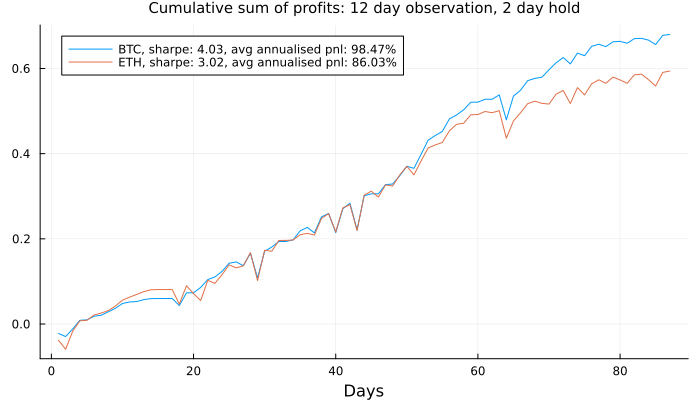

In [13]:
coins = ["BTC", "ETH"]

if length(index) ==2
    
    plot(pv[1],label = "BTC, sharpe: $(s[1]), avg annualised pnl: $(avg_p[1])%", size=(700,400))
    plot!(pv[2],label = "ETH, sharpe: $(s[2]), avg annualised pnl: $(avg_p[2])%", size=(700,400))    
    
    
else
    plot(pv[end],label = "$(coins[index[end]]), sharpe: $(s[end]), avg annualised pnl: $(avg_p[end])%", size=(700,400))
    end
xlabel!("Days")

title!("Cumulative sum of profits: $(hp["obs"]) day observation, $(hp["hold"]) day hold", titlefont = font(10))



In [12]:
model = res.model
using BSON: @save
using Dates

timestamp = string(Dates.today())

@save timestamp*"cryptomodel"*".bson" model

In [13]:
cp(timestamp*"cryptomodel"*".bson", "../../code/"*"cryptomodel"*".bson", force = true)

"../../code/cryptomodel.bson"